In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import glob
import json
import re

In [2]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

In [3]:
!ls -l /home/bi2i/Projects/covid_19_dataset

total 64340
-rw-rw-r-- 1 bi2i covid19    26690 Mar 20 23:32  COVID.DATA.LIC.AGMT.pdf
-rw-rw-r-- 1 bi2i covid19  3055634 Mar 23 11:00 'Kaggle data pull code.ipynb'
drwxrwsr-x 3 bi2i covid19     4096 Mar 23 10:48  biorxiv_medrxiv
drwxrwsr-x 3 bi2i covid19     4096 Mar 23 10:48  comm_use_subset
drwxrwsr-x 3 bi2i covid19     4096 Mar 23 10:49  custom_license
-rw-rw-r-- 1 bi2i covid19     2906 Mar 20 23:37  json_schema.txt
-rw-rw-r-- 1 bi2i covid19       69 Mar 23 10:45  kaggle.json
-rw-rw-r-- 1 bi2i covid19 62763644 Mar 20 23:37  metadata.csv
-rw-rw-r-- 1 bi2i covid19     1574 Mar 20 23:37  metadata.readme
drwxrwsr-x 3 bi2i covid19     4096 Mar 23 10:49  noncomm_use_subset


In [4]:
root_path = '/home/bi2i/Projects/covid_19_dataset'
metadata_path = f'{root_path}/metadata.csv'
metadata = pd.read_csv(metadata_path, dtype={
    'pubmed_id': str,
    'Microsoft Academic Paper ID': str, 
    'doi': str
})
metadata.head()

,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text,full_text_file
0,NaN,Elsevier,Intrauterine virus infections and congenital h...,10.1016/0002-8703(72)90077-4,NaN,4361535,els-covid,Abstract The etiologic basis for the vast majo...,1972-12-31,"Overall, James C.",American Heart Journal,NaN,NaN,False,custom_license
1,NaN,Elsevier,Coronaviruses in Balkan nephritis,10.1016/0002-8703(80)90355-5,NaN,6243850,els-covid,NaN,1980-03-31,"Georgescu, Leonida; Diosi, Peter; Buţiu, Ioan;...",American Heart Journal,NaN,NaN,False,custom_license
2,NaN,Elsevier,Cigarette smoking and coronary heart disease: ...,10.1016/0002-8703(80)90356-7,NaN,7355701,els-covid,NaN,1980-03-31,"Friedman, Gary D",American Heart Journal,NaN,NaN,False,custom_license
3,aecbc613ebdab36753235197ffb4f35734b5ca63,Elsevier,Clinical and immunologic studies in identical ...,10.1016/0002-9343(73)90176-9,NaN,4579077,els-covid,"Abstract Middle-aged female identical twins, o...",1973-08-31,"Brunner, Carolyn M.; Horwitz, David A.; Shann,...",The American Journal of Medicine,NaN,NaN,True,custom_license
4,NaN,Elsevier,Epidemiology of community-acquired respiratory...,10.1016/0002-9343(85)90361-4,NaN,4014285,els-covid,Abstract Upper respiratory tract infections ar...,1985-06-28,"Garibaldi, Richard A.",The American Journal of Medicine,NaN,NaN,False,custom_license


In [5]:
clean_dates = []
dates = metadata['publish_time'].values
for date in dates:
    try:
        date = str(date)
        if date != 'nan':
            match = re.search(r"(\d{4})", date)
#             print(date, match[0])
            if match:
                clean_dates.append(match[0])
        else:
            clean_dates.append(None)
    except ValueError as e:
        pass
    

for date in clean_dates[:5]:
    print(date)

1972
1980
1980
1973
1985


In [6]:
all_json = glob.glob(f'{root_path}/**/*.json', recursive=True)
all_json.pop(0)
print(all_json[0], len(all_json))

/home/bi2i/Projects/covid_19_dataset/custom_license/custom_license/43e9892ae110c84658e8b7d5ec4467efd3d12f11.json 29315


In [7]:
class FileReader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            self.abstract = []
            self.body_text = []
            # Abstract
            for entry in content['abstract']:
                self.abstract.append(entry['text'])
            # Body text
            for entry in content['body_text']:
                self.body_text.append(entry['text'])
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)
            # Extend Here
            #
            #
    def __repr__(self):
        return f'{self.paper_id}: {self.abstract[:200]}... {self.body_text[:200]}...'
first_row = FileReader(all_json[1])
print(first_row)

ba8577fbe95f71f3482edea00b9e7579bc360799: Since the first case of human infection by the Middle East respiratory syndrome coronavirus (MERS-CoV) in Saudi Arabia in June 2012, more than 2260 cases of confirmed MERS-CoV infection and 803 relate... The first case of infection attributed to Middle East respiratory syndrome coronavirus (MERS-CoV) was detected in Saudi Arabia in June 2012 [1] . MERS-CoV then spread to several neighboring countries,...


In [8]:
dict_ = {'paper_id': [], 'abstract': [], 'body_text': []}
for idx, entry in enumerate(all_json):
    if idx % (len(all_json) // 10) == 0:
        print(f'Processing index: {idx} of {len(all_json)}')
    content = FileReader(entry)
    dict_['paper_id'].append(content.paper_id)
    dict_['abstract'].append(content.abstract)
    dict_['body_text'].append(content.body_text)
df_covid = pd.DataFrame(dict_, columns=['paper_id', 'abstract', 'body_text'])
df_covid.head()

Processing index: 0 of 29315
Processing index: 2931 of 29315
Processing index: 5862 of 29315
Processing index: 8793 of 29315
Processing index: 11724 of 29315
Processing index: 14655 of 29315
Processing index: 17586 of 29315
Processing index: 20517 of 29315
Processing index: 23448 of 29315
Processing index: 26379 of 29315
Processing index: 29310 of 29315


,paper_id,abstract,body_text
0,43e9892ae110c84658e8b7d5ec4467efd3d12f11,,Previous chapters examined public health-relat...
1,ba8577fbe95f71f3482edea00b9e7579bc360799,Since the first case of human infection by the...,The first case of infection attributed to Midd...
2,90d1d04a22ec4e9f4e1e0d63053a99784ca489d6,Sarcoids are the most prevalent equine skin tu...,Sarcoids are the most common equine skin tumou...
3,5f5b18b0f7c14a78216c49da9a13712161fe5750,Dendritic cells which are located at the inter...,"Dendritic cells (DCs) , which are present in t..."
4,f0dea096a4f73085b277b6977c8c3367b2957a6e,To study the effectiveness of noninvasive posi...,S evere acute respiratory syndrome (SARS) was ...


In [9]:
df_covid['abstract_word_count'] = df_covid['abstract'].apply(lambda x: len(x.strip().split()))
df_covid['body_word_count'] = df_covid['body_text'].apply(lambda x: len(x.strip().split()))
df_covid.head()

,paper_id,abstract,body_text,abstract_word_count,body_word_count
0,43e9892ae110c84658e8b7d5ec4467efd3d12f11,,Previous chapters examined public health-relat...,0,15004
1,ba8577fbe95f71f3482edea00b9e7579bc360799,Since the first case of human infection by the...,The first case of infection attributed to Midd...,384,4785
2,90d1d04a22ec4e9f4e1e0d63053a99784ca489d6,Sarcoids are the most prevalent equine skin tu...,Sarcoids are the most common equine skin tumou...,175,3019
3,5f5b18b0f7c14a78216c49da9a13712161fe5750,Dendritic cells which are located at the inter...,"Dendritic cells (DCs) , which are present in t...",113,7051
4,f0dea096a4f73085b277b6977c8c3367b2957a6e,To study the effectiveness of noninvasive posi...,S evere acute respiratory syndrome (SARS) was ...,336,2560


In [10]:
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29315 entries, 0 to 29314
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   paper_id             29315 non-null  object
 1   abstract             29315 non-null  object
 2   body_text            29315 non-null  object
 3   abstract_word_count  29315 non-null  int64 
 4   body_word_count      29315 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 1.1+ MB


In [11]:
df_covid.describe(include='all')

,paper_id,abstract,body_text,abstract_word_count,body_word_count
count,29315,29315,29315,29315.000000,29315.000000
unique,29315,21050,29117,NaN,NaN
top,49a4bfa8b9c99380d686b6582b76f55fdff7d722,,"In previous reports, workers have characterize...",NaN,NaN
freq,1,8051,4,NaN,NaN
mean,NaN,NaN,NaN,164.501313,4802.289033
std,NaN,NaN,NaN,175.353341,7322.709102
min,NaN,NaN,NaN,0.000000,1.000000
25%,NaN,NaN,NaN,0.000000,2444.000000
50%,NaN,NaN,NaN,161.000000,3730.000000
75%,NaN,NaN,NaN,240.000000,5509.500000


In [12]:
df_covid.drop_duplicates(['abstract'], inplace=True)
df_covid.describe(include='all')

,paper_id,abstract,body_text,abstract_word_count,body_word_count
count,21050,21050,21050,21050.000000,21050.000000
unique,21050,21050,21045,NaN,NaN
top,6c6b13bdca7f70d6afec7257e4769bb5c10b1a19,Global terrorism is a rapidly growing threat t...,Gastrointestinal disorders are frequently repo...,NaN,NaN
freq,1,1,2,NaN,NaN
mean,NaN,NaN,NaN,227.180855,4594.601235
std,NaN,NaN,NaN,168.553834,5557.126730
min,NaN,NaN,NaN,0.000000,1.000000
25%,NaN,NaN,NaN,149.000000,2736.250000
50%,NaN,NaN,NaN,203.000000,3862.000000
75%,NaN,NaN,NaN,263.750000,5471.000000


In [13]:
df_covid.head()

,paper_id,abstract,body_text,abstract_word_count,body_word_count
0,43e9892ae110c84658e8b7d5ec4467efd3d12f11,,Previous chapters examined public health-relat...,0,15004
1,ba8577fbe95f71f3482edea00b9e7579bc360799,Since the first case of human infection by the...,The first case of infection attributed to Midd...,384,4785
2,90d1d04a22ec4e9f4e1e0d63053a99784ca489d6,Sarcoids are the most prevalent equine skin tu...,Sarcoids are the most common equine skin tumou...,175,3019
3,5f5b18b0f7c14a78216c49da9a13712161fe5750,Dendritic cells which are located at the inter...,"Dendritic cells (DCs) , which are present in t...",113,7051
4,f0dea096a4f73085b277b6977c8c3367b2957a6e,To study the effectiveness of noninvasive posi...,S evere acute respiratory syndrome (SARS) was ...,336,2560


In [14]:
df_covid['body_text'] = df_covid['body_text'].apply(lambda x: re.sub('[^a-zA-z0-9\s]','',x))
df_covid['abstract'] = df_covid['abstract'].apply(lambda x: re.sub('[^a-zA-z0-9\s]','',x))

In [15]:
def lower_case(input_str):
    input_str = input_str.lower()
    return input_str

df_covid['body_text'] = df_covid['body_text'].apply(lambda x: lower_case(x))
df_covid['abstract'] = df_covid['abstract'].apply(lambda x: lower_case(x))

df_covid.head(4)

,paper_id,abstract,body_text,abstract_word_count,body_word_count
0,43e9892ae110c84658e8b7d5ec4467efd3d12f11,,previous chapters examined public healthrelate...,0,15004
1,ba8577fbe95f71f3482edea00b9e7579bc360799,since the first case of human infection by the...,the first case of infection attributed to midd...,384,4785
2,90d1d04a22ec4e9f4e1e0d63053a99784ca489d6,sarcoids are the most prevalent equine skin tu...,sarcoids are the most common equine skin tumou...,175,3019
3,5f5b18b0f7c14a78216c49da9a13712161fe5750,dendritic cells which are located at the inter...,dendritic cells dcs which are present in the ...,113,7051


In [16]:
text = df_covid.drop(["paper_id", "abstract", "abstract_word_count", "body_word_count"], axis=1)
text.head(5)

,body_text
0,previous chapters examined public healthrelate...
1,the first case of infection attributed to midd...
2,sarcoids are the most common equine skin tumou...
3,dendritic cells dcs which are present in the ...
4,s evere acute respiratory syndrome sars was fi...


In [17]:
text_arr = text.stack().tolist()
len(text_arr)

21050

In [18]:
words = []
for ii in range(0,len(text)):
    words.append(str(text.iloc[ii]['body_text']).split(" "))

print(words[0][0])

previous


In [19]:
n_gram_all = []

for word in words:
    # get n-grams for the instance
    n_gram = []
    for i in range(len(word)-2+1):
        n_gram.append("".join(word[i:i+2]))
    n_gram_all.append(n_gram)

n_gram_all[0][0]

'previouschapters'

In [20]:
# hash vectorizer instance
hvec = HashingVectorizer(lowercase=False, analyzer=lambda l:l, n_features=2**12)

# features matrix X
X = hvec.fit_transform(n_gram_all)

X.shape

(21050, 4096)

In [21]:
# test set size of 20% of the data and the random seed 42 <3
X_train, X_test = train_test_split(X.toarray(), test_size=0.2, random_state=42)

print("X_train size:", len(X_train))
print("X_test size:", len(X_test), "\n")

X_train size: 16840
X_test size: 4210 



In [22]:
tsne = TSNE(verbose=1, perplexity=5)
X_embedded = tsne.fit_transform(X_train)

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 16840 samples in 14.245s...
[t-SNE] Computed neighbors for 16840 samples in 2310.423s...
[t-SNE] Computed conditional probabilities for sample 1000 / 16840
[t-SNE] Computed conditional probabilities for sample 2000 / 16840
[t-SNE] Computed conditional probabilities for sample 3000 / 16840
[t-SNE] Computed conditional probabilities for sample 4000 / 16840
[t-SNE] Computed conditional probabilities for sample 5000 / 16840
[t-SNE] Computed conditional probabilities for sample 6000 / 16840
[t-SNE] Computed conditional probabilities for sample 7000 / 16840
[t-SNE] Computed conditional probabilities for sample 8000 / 16840
[t-SNE] Computed conditional probabilities for sample 9000 / 16840
[t-SNE] Computed conditional probabilities for sample 10000 / 16840
[t-SNE] Computed conditional probabilities for sample 11000 / 16840
[t-SNE] Computed conditional probabilities for sample 12000 / 16840
[t-SNE] Computed conditional probabilities for

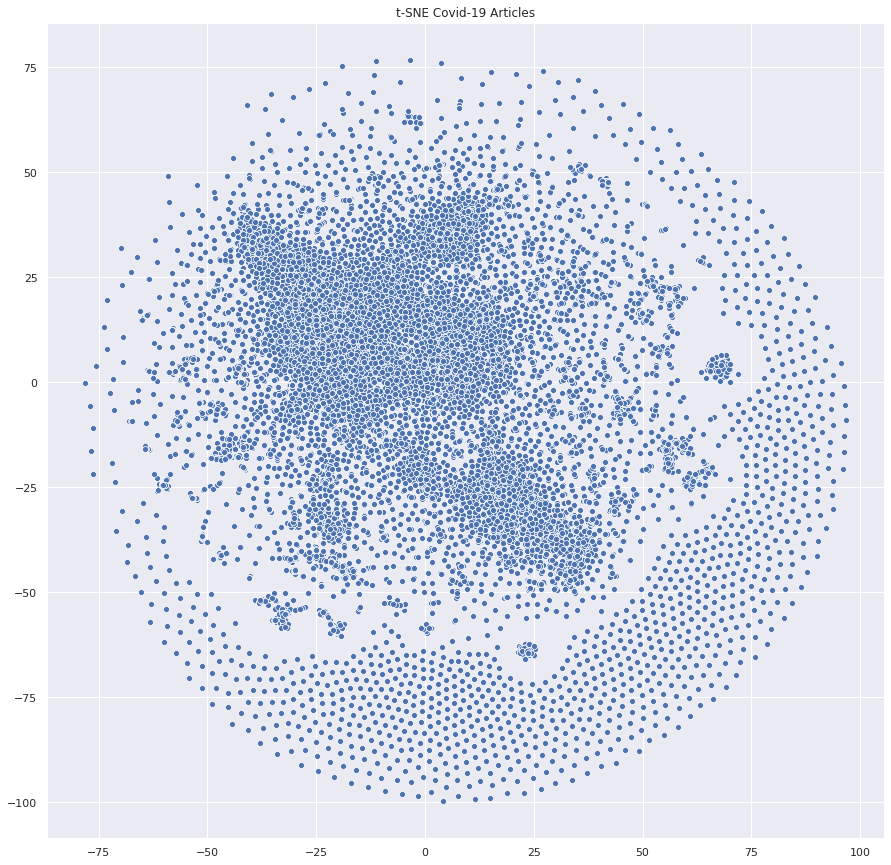

In [23]:
# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], palette=palette)

plt.title("t-SNE Covid-19 Articles")
#plt.savefig("plots/t-sne_covid19.png")
plt.show()

In [24]:
k = 10
kmeans = KMeans(n_clusters=k, n_jobs=4, verbose=10)
y_pred = kmeans.fit_predict(X_train)

In [25]:
y_train = y_pred
y_test = kmeans.predict(X_test)

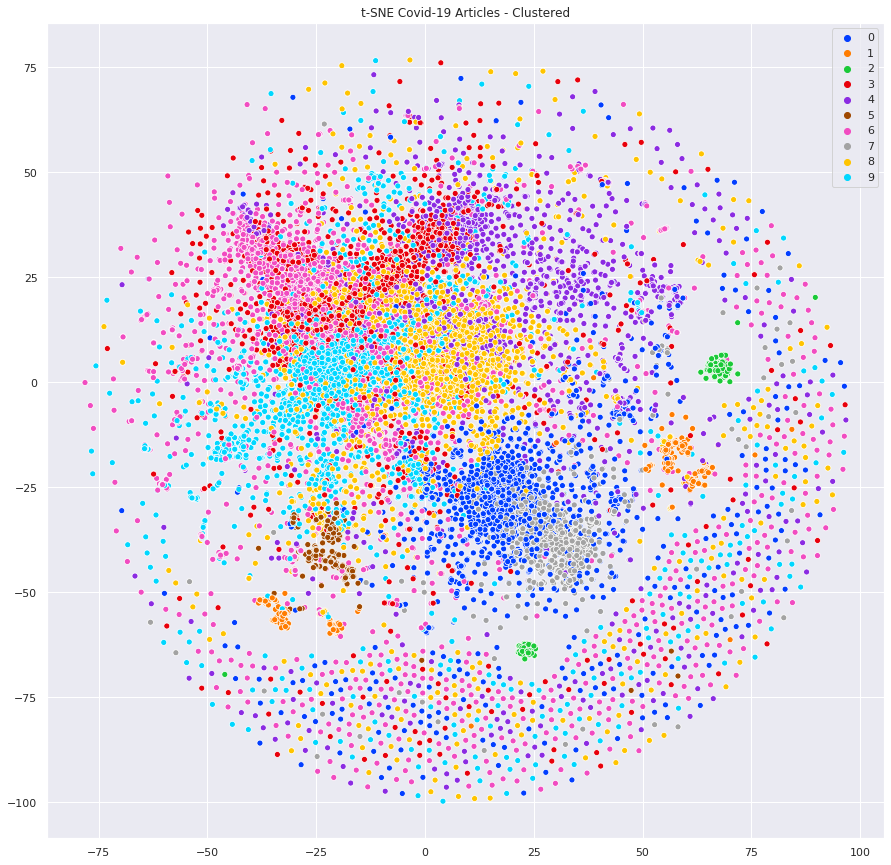

In [26]:
# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", len(set(y_pred)))

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title("t-SNE Covid-19 Articles - Clustered")
#plt.savefig("plots/t-sne_covid19_label.png")
plt.show()